# Transfer Learning Example with Google Colab.

This notebook contains a simple tutorial of the trasnfer learning.

## Reference

[Pytorch tutorial for transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Main Implementation

Before run this code, 
**Make sure that you have enabled the GPU under Edit -> Notebook Settings.**

In this example, we will use ResNet18 pretrained model to classify the small dataset. We will focus on classifying bees and ants. We will initialize the network with a pretrained network and change the last fully connected layer with two outputs. And we will train the network. 

First, let's download small dataset that only contains the data of bees and ants. To do this, we need to access your google drive to save the dataset. Click the link next "Go to this URL in a browser" and copy/paste the authorization code.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/')
os.getcwd()
if not os.path.exists('data'):
        os.makedirs('data')
os.chdir('data')

# download the small dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

os.chdir('..')

%matplotlib inline
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2020-08-06 04:28:41--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.191.57, 143.204.191.59, 143.204.191.91, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.191.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  41.9MB/s    in 1.1s    

2020-08-06 04:28:43 (41.9 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace hymenoptera_data/train/ants/103002

Next, let's define the dataset in pytorch. We can normalize and set the type of the dataset by using below code: 

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Here is an example for the dataset 

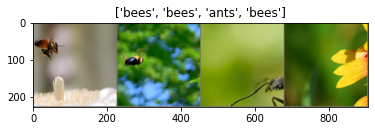

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


### Visualizing a model 


In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Next, we will load a pretrained Resnet18 model from torchivision.models. We can even reset final layer of the pretrained Resnet. 

In [9]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
model = train(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6087 Acc: 0.6967
val Loss: 0.1786 Acc: 0.9281

Epoch 1/9
----------
train Loss: 0.4652 Acc: 0.7992
val Loss: 0.4301 Acc: 0.8301

Epoch 2/9
----------
train Loss: 0.6456 Acc: 0.7213
val Loss: 0.3278 Acc: 0.8824

Epoch 3/9
----------
train Loss: 0.4815 Acc: 0.8033
val Loss: 0.2405 Acc: 0.9216

Epoch 4/9
----------
train Loss: 0.6582 Acc: 0.7459
val Loss: 0.3822 Acc: 0.8562

Epoch 5/9
----------
train Loss: 0.6748 Acc: 0.7664
val Loss: 0.2524 Acc: 0.9216

Epoch 6/9
----------
train Loss: 0.5038 Acc: 0.8033
val Loss: 0.2608 Acc: 0.9085

Epoch 7/9
----------
train Loss: 0.3438 Acc: 0.8607
val Loss: 0.2292 Acc: 0.9412

Epoch 8/9
----------
train Loss: 0.2940 Acc: 0.8730
val Loss: 0.2327 Acc: 0.9216

Epoch 9/9
----------
train Loss: 0.3246 Acc: 0.8648
val Loss: 0.1924 Acc: 0.9412

Training complete in 1m 0s
Best val Acc: 0.941176


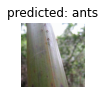

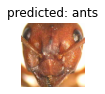

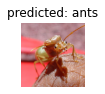

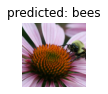

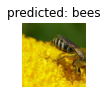

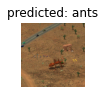

In [11]:
visualize_model(model)
